### Comet Experiement
Comet will be used for version control

In [1]:
# import comet_ml at the top of your file
import comet_ml
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="uIA4LnUcw5MgXtaoZFKhjA8kp",
    project_name="team-2-unsupervised",
    workspace="bravo",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/bravo/team-2-unsupervised/5a7aed21e49742ef804c07a9e55e047e



### Import libraries and packages

In [2]:

import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS
import time



# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from sklearn.cluster import KMeans
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD, BaselineOnly, CoClustering, NMF
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

### Import data

In [3]:
sample_submission = pd.read_csv('sample_submission.csv')
movies = pd.read_csv('movies.csv')
imdb = pd.read_csv('imdb_data.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# 3. DATA VIEWING
---

Following the necessary imports is for viewing the data to see what information we can get from it.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [6]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [7]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [9]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [11]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [12]:
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [13]:
dataset=pd.merge(train,movies,on='movieId')

In [14]:
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [15]:
dataset1=pd.merge(imdb,movies,on='movieId')

In [16]:
dataset1.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy


# 4. DATA PREPROCESSING
---

Firstly, we check if our data has any null values, missing values and blank spaces.

In [17]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [18]:
test.isnull().sum()

userId     0
movieId    0
dtype: int64

In [19]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [20]:
imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

In [21]:
genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [22]:
genome_tags.isnull().sum()

tagId    0
tag      0
dtype: int64

In [23]:
tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [24]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [25]:
blanks = []  

for ms in movies.itertuples():  
    if type(ms)==str:            
        if ms.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [26]:
blanks = []  

for ms in imdb.itertuples():  
    if type(ms)==str:            
        if ms.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [27]:
blanks = []  

for ms in genome_scores.itertuples():  
    if type(ms)==str:            
        if ms.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [28]:
blanks = []  

for ms in tags.itertuples():  
    if type(ms)==str:            
        if ms.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [29]:
blanks = []  

for ms in links.itertuples():  
    if type(ms)==str:            
        if ms.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


# 5. EXPLORATORY DATA ANALYSIS
---

Now let us begin the process of exploring our data. This process will be referred to as Exploratory Data Analysis or EDA. The reason we explore the data is to gain insight on the data and how it behaves. Exploratory data analysis (EDA) is a term for certain kinds of initial analysis and findings done with data sets, usually early on in an analytical process. Some experts describe it as “taking a peek” at the data to understand more about what it represents and how to apply it.

### Most common genres

In [30]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


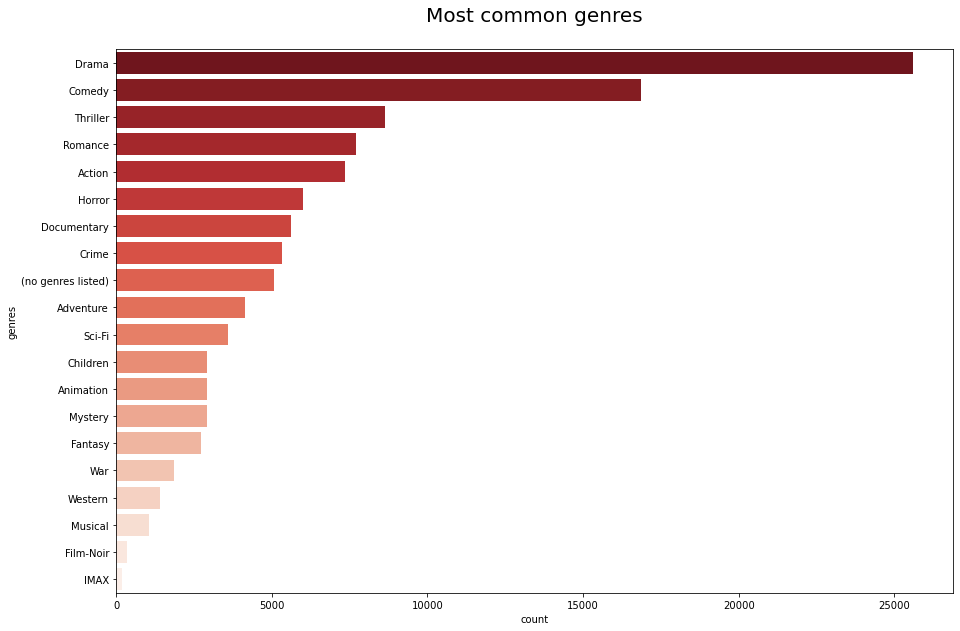

In [31]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

##### Observation:
The graph above shows that the most common genres are drama, comedy, thriller, etc. People love drama movies more than any other genre therefore more of those should always form part of a user's recommendation. Children and animation genres are equally common and this could be attributed to the fact that most children's movies are animated.

### Ratings per user

In [32]:
train1 = train.copy()
train1.drop('timestamp', axis = 1, inplace = True)

In [33]:
ratings_per_user = train1.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)
ratings_per_user

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
...,...,...
79086,79087,1
53639,53640,1
105713,105714,1
121070,121071,1


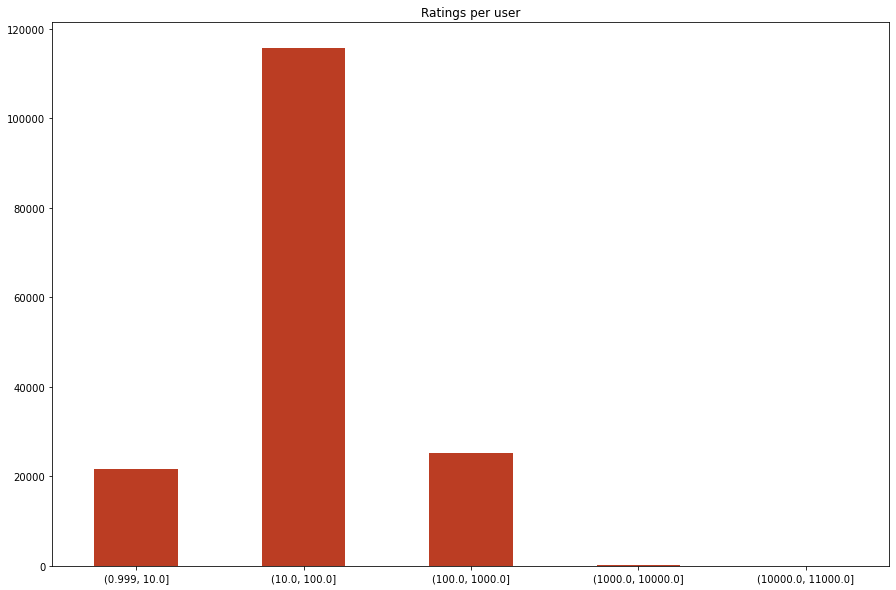

In [34]:
#create a list of the ratings in order to create a bar graph from the list 
ratings_list = ratings_per_user['rating'].tolist()
out = pd.cut(ratings_list, bins=[1,10,100,1000,10000,11000], include_lowest = True)
ax = out.value_counts().plot.bar(rot=0, color="#bb3d23", figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels())
plt.title('Ratings per user')
plt.show()

##### Observation: 
The bar graph above shows the number of times users have made ratings. About 20 000 users have only rated movies less than 
10 times while more than 100 000 have rated more than 10 times. There are super rators, such as userID 72315 that have made more than 10 000 ratings.
Insight drawn from this graph is that a lot of people do rate movies therefore a recommender system is worth the investment. 

### Distribution of ratings

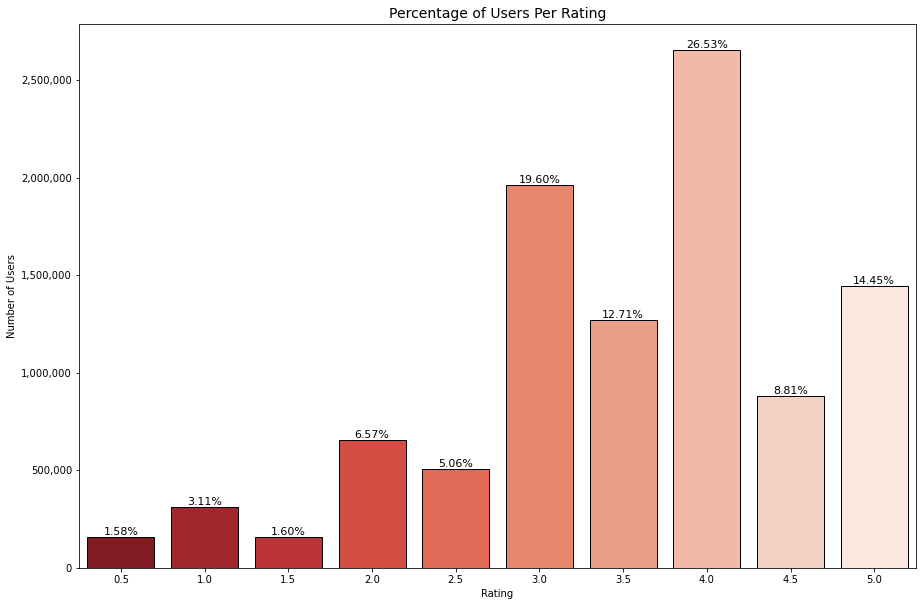

In [35]:
sub_df= train['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=sub_df, x='index', y='rating', palette="Reds_r", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(sub_df['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350,
            '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Percentage of Users Per Rating', fontsize=14)
plt.show()

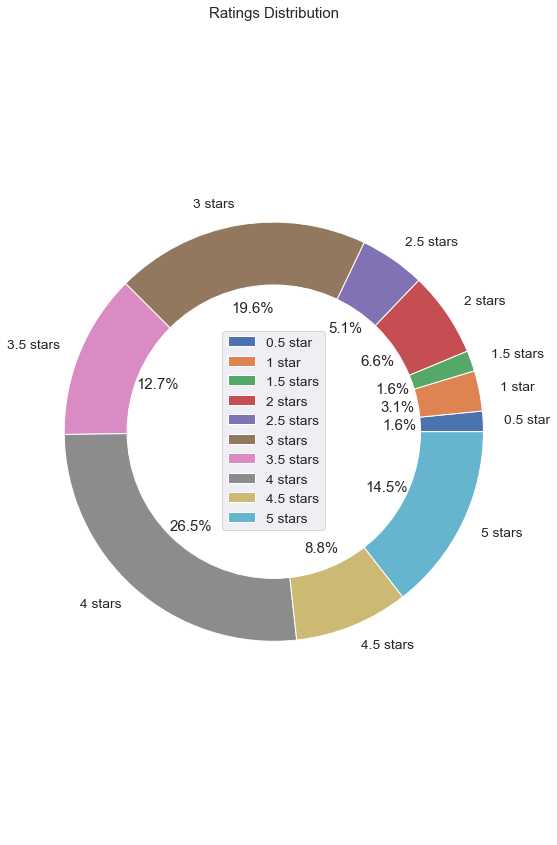

In [36]:
# Create the colour palette
labels = '0.5 star','1 star','1.5 stars','2 stars','2.5 stars','3 stars','3.5 stars','4 stars','4.5 stars','5 stars'
sizes = (train['rating'].value_counts().sort_index()).tolist()
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)


fig1, ax1 = plt.subplots(figsize=(8,12))
pie = ax1.pie(sizes, labels=labels,autopct='%1.1f%%')
ax1.axis('equal') 
#plt.title('Ratings Distribution')

# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
plt.title('Ratings Distribution')
#ax.set_title('Rating distribution', fontsize=15)
plt.legend(pie[0], labels, loc="center")
plt.tight_layout()
plt.show()



##### Observation:
The train distribution shows that there are relatively fewer movies that are lower rated. This can be because most of the users who didn't like the movie, didn't care enough to rate the movie. You should note this, it can be useful later. As you wouldn't want to recommend movies with relatively low number of ratings as users probably didn't like them.

4 Star ratings make up the largest portion of ratings in the MovieLens dataset, accounting for 26.5% of the overall ratings.
5 star ratings make up 14.5% of the overall ratings (3rd largest portion).
0.5 star ratings account for the smallest portion of the ratings at a mere 1.6%.
Ratings between 2 and 0.5 stars account for 12.9%

### Most appearing director

In [37]:
imdb['director'].nunique()

11786

In [38]:
def count_directors(df, count = 10):
    directors = pd.DataFrame(df['director'].value_counts()).reset_index()
    directors.columns = ['director', 'count']
    # Lets only take directors who have made 10 or more movies otherwise we will have to analyze 11000 directors
    directors = directors[directors['count']>=count]
    return directors.sort_values('count', ascending = False)

In [39]:
def feature_count(df, column):
    plt.figure(figsize=(14,7))
    ax = sns.barplot(x = df[f'{column}'], y= df['count'], palette='Reds_r')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

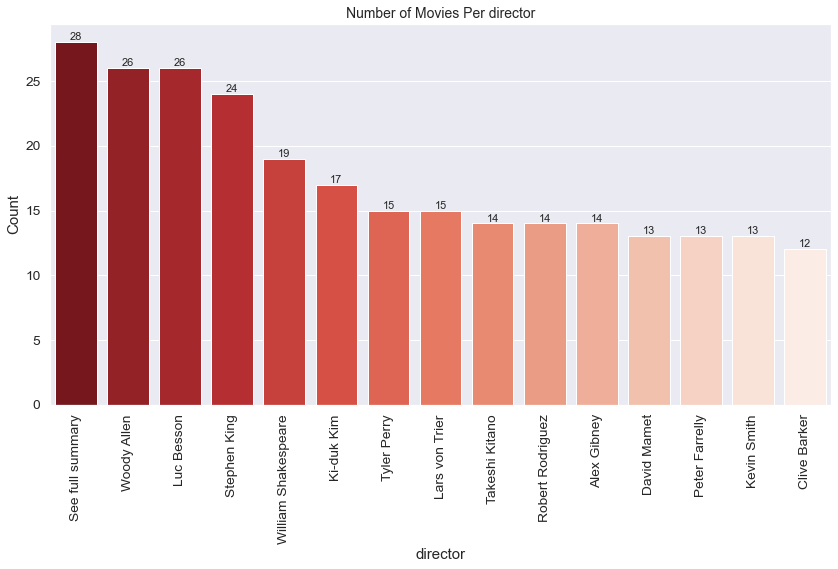

In [40]:
directors = count_directors(imdb)
feature_count(directors.head(15), 'director')

In [41]:
dataset2 = dataset1.head(500)

In [42]:
dataset2.isna().sum()

movieId            0
title_cast         7
director           7
runtime           27
budget           180
plot_keywords     10
title              0
genres             0
dtype: int64

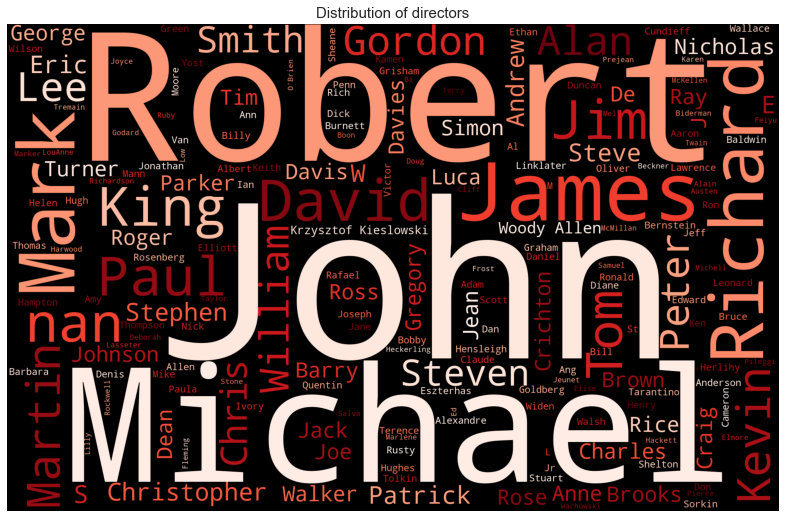

In [43]:
popular_directors = pd.DataFrame(dataset2['director'].value_counts())
popular_directors = popular_directors.head(10)

# Wordcloud of TAGS
directors = dataset2['director'] = dataset2['director'].astype('str')
directors_wordcloud = ' '.join(directors)
direct_wordcloud = WordCloud(stopwords = STOPWORDS,
                            background_color = 'Black',
                            height = 1200,
                            width = 1900,
                           colormap='Reds').generate(directors_wordcloud)
plt.figure(figsize = (14,7), facecolor=None)
plt.imshow(direct_wordcloud)
plt.axis('off')
plt.title('Distribution of directors')
plt.tight_layout(pad=0)
plt.show()

##### Observation:
From above we can see that some directors have directed movies a lot more than others. We have Luc Besson with the most directs at 26 movies and some directors at only 12 movies. The number of times directors have worked on a movie helps better understand their directing style and how they are likely to be rated. With this information, we should be able to make better recommendations based on the popularity of the director and their track record.

### Total movies released per year

In [44]:
movies['release_year']=movies['title'].str[-5:-1] #extracting released year
movies['genres']=movies['genres'].str.split('|') #spliting the genres into a list
movies=pd.concat([movies,train['rating']],axis=1).dropna() #concatinate ratings with movies dataframe
movies.head()

,movieId,title,genres,release_year,rating
0,1.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,4.0
1,2.0,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,4.5
2,3.0,Grumpier Old Men (1995),"[Comedy, Romance]",1995,5.0
3,4.0,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,2.0
4,5.0,Father of the Bride Part II (1995),[Comedy],1995,3.0


In [45]:
imdb['title_cast']=imdb['title_cast'].str.split('|') #spliting the title cast into a list
imdb['plot_keywords']=imdb['plot_keywords'].str.split('|') #spliting the Key words into a list
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgi animation]"
1,2,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Jonathan Hensleigh,104.0,"$65,000,000","[board game, adventurer, fight, game]"
2,3,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...",Mark Steven Johnson,101.0,"$25,000,000","[boat, lake, neighbor, rivalry]"
3,4,"[Whitney Houston, Angela Bassett, Loretta Devi...",Terry McMillan,124.0,"$16,000,000","[black american, husband wife relationship, be..."
4,5,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Albert Hackett,106.0,"$30,000,000","[fatherhood, doberman, dog, mansion]"


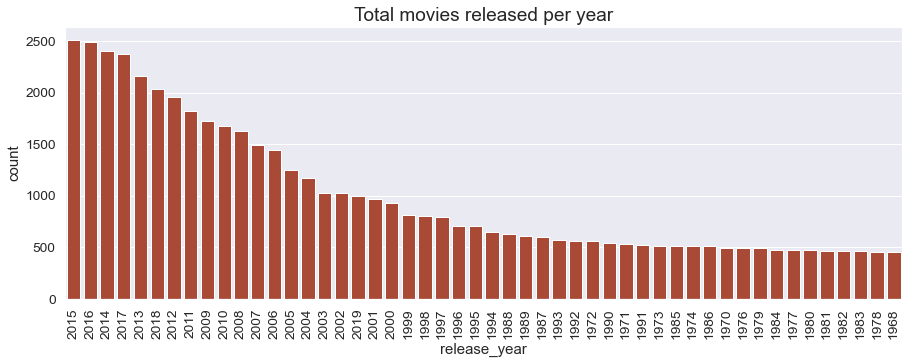

In [46]:
#Plotting total amount of movies released in each year using a count plot.
figure= plt.subplots(figsize=(15, 5))
axes=sns.countplot(x=movies['release_year'], order = movies['release_year'].value_counts()[0:50].index,color='#bb3d23')
axes.set_title('Total movies released per year',fontsize=19)
plt.xticks(rotation=90)
plt.show()

##### Observation:
Above, we observe that the years 2015 and 2016 are the years where the highest number of movies were released.What the diagram above communicates to us is that as the years progress, the amount of movies being released have significantly increased.
This can be largely attributed to the fact that technology has changed a lot of industries and entry into these industry allows for fair competition and variety. 

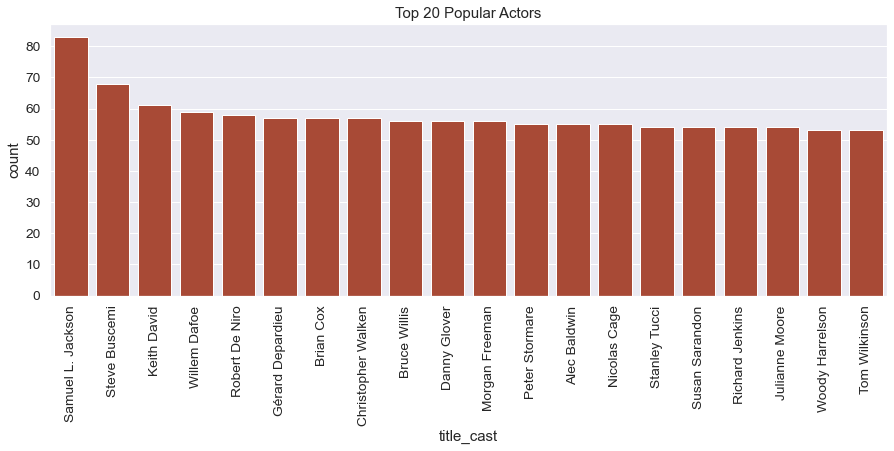

In [47]:
#Plotting popular cast using a count-plot
plt.figure(figsize = (15,5))
title_cast=imdb['title_cast'].explode()
ax=sns.countplot(x=title_cast, order = title_cast.value_counts().index[:20],color='#bb3d23')
ax.set_title('Top 20 Popular Actors',fontsize=15)
plt.xticks(rotation=90)
plt.show()

##### Observation:
Actors and actresses are artists that have a following and a fanbase. Some actors are contracted more than others. The graph above shows that Samuel L Jackson has been in more than 80 movies. Other famous actors as well have been featured a large number of times. People are likely to watch a movie that has their favourite actor in the movie and these artists wouldn't have been featured so many times if they weren't good. 

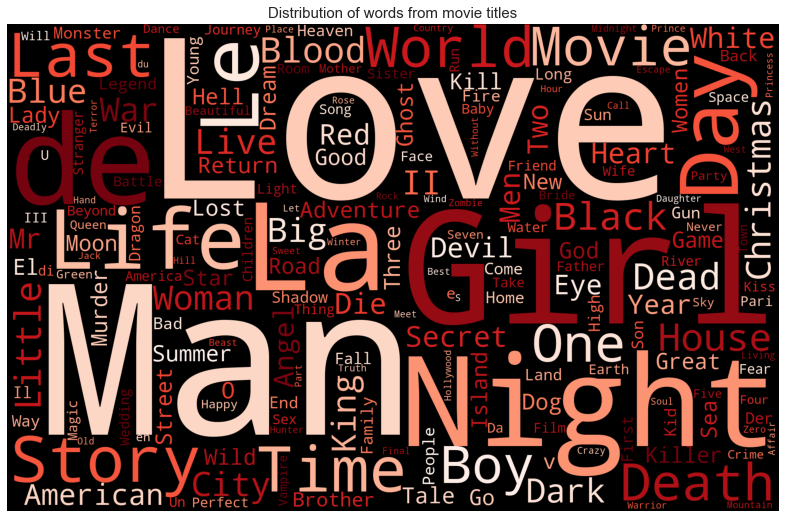

In [48]:
# Wordcloud of movie titles
movies_word = movies['title'] = movies['title'].astype('str')
movies_wordcloud = ' '.join(movies_word)
title_wordcloud = WordCloud(stopwords = STOPWORDS,
                            background_color = 'Black',
                            height = 1200,
                            width = 1900,
                           colormap='Reds').generate(movies_wordcloud)
plt.figure(figsize = (14,7), facecolor=None)
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Distribution of words from movie titles')
plt.tight_layout(pad=0)
plt.show()

##### Observation:
The visual above shows which words are commonly used when movies are titled. The bigger the word, the more it is being used. As can be seen, the word "love", "Man", and "Girl" appears the most.

In [49]:
#check number of repeating titles. 
repeating_movies = pd.DataFrame(movies['title'].value_counts())
repeating_movies['title'].value_counts()

1    62227
2       98
Name: title, dtype: int64

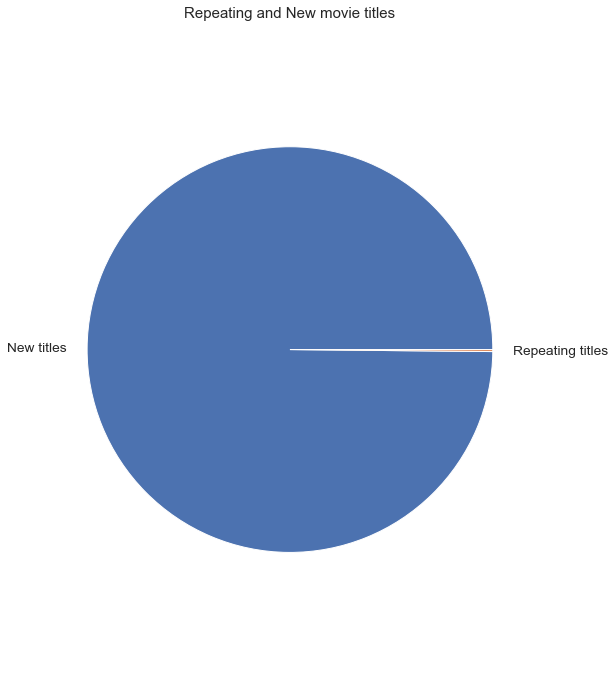

In [50]:
#create parameters for the graph
repeat_df = pd.DataFrame(repeating_movies['title'].value_counts())
repeat_df

label = 'New titles','Repeating titles'
size = repeating_movies['title'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8,12))
ax1.pie(size, labels=label)
ax1.axis('equal') 
plt.title('Repeating and New movie titles')
plt.show()

##### Observation:
From the graph it looks insignificant but most movies titles have only been used once but about 98 movie titles have been used twice. This may cause some confusion for the customers therefore producers are encouraged to avoid using cliche or already used titles that way the movies are not skipped when they come up recommendations (user might assume they have already seen it)

# 6. MODELLING
---


# Building the reccomender system
Recommender systems function with two kinds of information:

- Characteristic information: This is information about items (keywords, categories, etc.) and users (preferences, profiles, etc.).

- User-item interactions: This is information such as ratings, number of purchases, likes, etc.

Based on this, we can distinguish between three algorithms used in recommender systems

# CONTENT BASED FILTERING
Idea: If you like an item then you will also like a “similar” item






In [51]:
# Convert data types to strings for string handling
dataset1['title_cast'] = dataset1.title_cast.astype(str)
dataset1['plot_keywords'] = dataset1.plot_keywords.astype(str)
dataset1['genres'] = dataset1.genres.astype(str)
dataset1['director'] = dataset1.director.astype(str)

In [52]:
# Creating an empty column and list to store the corpus for each movie
dataset1['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(dataset1['movieId'])):
    words = ''
    for col in columns:
        words = words + dataset1.iloc[i][col] + " "        
    corpus.append(words)
    # Add the corpus information for each movie to the dataframe 
dataset1['corpus'] = corpus
dataset1.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
dataset1.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

dataset1.head()

,runtime,budget,title,corpus
movieId,,,,
1,81.0,"$30,000,000",Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...
2,104.0,"$65,000,000",Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...
3,101.0,"$25,000,000",Grumpier Old Men (1995),Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...
4,124.0,"$16,000,000",Waiting to Exhale (1995),Whitney Houston|Angela Bassett|Loretta Devine|...
5,106.0,"$30,000,000",Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...


In [53]:
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset1['corpus'])


Similarity is calculated as the cosine of the angle between the 2 vectors of the item vectors of A and B. The closer the vectors, the smaller the angle and larger the cosine similarity.

![68747470733a2f2f7777772e6f7265696c6c792e636f6d2f6c6962726172792f766965772f737461746973746963732d666f722d6d616368696e652f393738313738383239353735382f6173736574732f326.png](attachment:68747470733a2f2f7777772e6f7265696c6c792e636f6d2f6c6962726172792f766965772f737461746973746963732d666f722d6d616368696e652f393738313738383239353735382f6173736574732f326.png)

In [54]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
print(cos_sim.shape)
cos_sim

(24866, 24866)


array([[1.        , 0.06063391, 0.06482037, ..., 0.0498548 , 0.020646  ,
        0.08968971],
       [0.06063391, 1.        , 0.02227177, ..., 0.03425944, 0.        ,
        0.04622502],
       [0.06482037, 0.02227177, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0498548 , 0.03425944, 0.        , ..., 1.        , 0.        ,
        0.01900372],
       [0.020646  , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.08968971, 0.04622502, 0.        , ..., 0.01900372, 0.        ,
        1.        ]])

In [55]:
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    # Create a a copy of the input dataframe where the index has been reset
    df1 = dataset1.reset_index()
    
    # Extract the movie titles
    titles = df1['title']
    indices = pd.Series(df1.index, index=dataset1['title'])
    idx = indices[title]
    
    # Get the similarity scores of the top n movies most similar to the user input
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n]
    
    # Exctract the titles of the top n most similar movies  
    movie_indices = [i[0] for i in sim_scores]
    
    return titles.iloc[movie_indices]

get_topN_recommendations('Ice Age (2002)').head(10)

10648           Ice Age 2: The Meltdown (2006)
13437    Ice Age: Dawn of the Dinosaurs (2009)
18129      Ice Age 4: Continental Drift (2012)
9591             Pooh's Heffalump Movie (2005)
16662                   Winnie the Pooh (2011)
24597    Tom and Jerry: The Lost Dragon (2014)
18330                    Runaway Brain (1995) 
12008    Walk Hard: The Dewey Cox Story (2007)
24823                   Superstar Goofy (1991)
Name: title, dtype: object

# COLLABORATIVE FILTERING

# Feature Engineering

In [56]:
# Load reader and data 
reader = Reader(rating_scale=(0.5, 5))
train2 = Dataset.load_from_df(train1[['userId', 'movieId', 'rating']], reader)


The models we are going to train are:
- Baseline Only model
- SVD model


# Hyperparameter tunning of best model

In [57]:
rating_scale = Reader(rating_scale=(0.5, 5))
train = Dataset.load_from_df(train.drop('timestamp', axis=1), rating_scale)

# Training and validation set split for hypertuning
train_set, val_set = train_test_split(train,
                                      test_size=0.008,
                                      random_state=42)

# Modelling of the SVD hypertuning
svd_algo_hyper = SVD(n_factors=160, 
                     lr_all=0.0085,
                     reg_all=0.02,
                     n_epochs=20,
                     init_std_dev=0.01)
svd_algo_hyper.fit(train_set)

# Predicting on the validation set
svd_hyper_predictions = svd_algo_hyper.test(val_set)

# Convert the predictions to dataframe
#test = pd.DataFrame(predictions)
accuracy.rmse(svd_hyper_predictions)

# Dictionary for the data to log for the SVD tuned model
params = {'model_name': 'SVD_Tuned'}
metrics = {'RMSE': accuracy.rmse(svd_hyper_predictions)}

RMSE: 0.7888
RMSE: 0.7888


Hyperparameter tuning makes the process of determining the best hyperparameter settings easier and less tedious. The model that has been tuned is the SVD model and the performance increased. 

In [58]:
mydict = {f'SVD Hyper': 0.7889,
          f'SVD': 0.8263,
          f'Baseline Only': 0.8652,
          f'NMF': 0.8810
         }

i = pd.DataFrame(mydict.items(), columns=['Model', 'RSME'])
i

,Model,RSME
0,SVD Hyper,0.7889
1,SVD,0.8263
2,Baseline Only,0.8652
3,NMF,0.8810


#### Making predictions

In [59]:
pred_svd_hyper = [svd_algo_hyper.predict(row.userId,
                                         row.movieId) for idx,row in test.iterrows()]

# Converting the predictions to a dataframe
test_pred_svd_hyper = pd.DataFrame(pred_svd_hyper)

#### Displaying predictions

In [60]:
#renaming the fields of the prediction dataframe
test_pred_svd_hyper.drop(['r_ui', 'details'], axis=1, inplace=True)
test_pred_svd_hyper = test_pred_svd_hyper.rename(columns={'uid':'userId',
                                                          'iid':'movieId',
                                                          'est':'rating'})
test_pred_svd_hyper.head()

,userId,movieId,rating
0,1,2011,3.036525
1,1,4144,4.187020
2,1,5767,3.804409
3,1,6711,4.023708
4,1,7318,2.801729


In [61]:
# Concatenating each userId and movieId to a single Id column for submission
test_pred_svd_hyper['Id'] =  test_pred_svd_hyper['userId'].astype(str).str.zfill(1) + '_' + test_pred_svd_hyper['movieId'].astype(str).str.zfill(1)

In [62]:
svd_hyper_predictions = test_pred_svd_hyper[['Id','rating']]
svd_hyper_predictions.head()

,Id,rating
0,1_2011,3.036525
1,1_4144,4.187020
2,1_5767,3.804409
3,1_6711,4.023708
4,1_7318,2.801729


In [63]:
svd_hyper_predictions[['Id','rating']].to_csv('MM2_submission.csv', index=False)

In [64]:
svd_hyper_predictions

,Id,rating
0,1_2011,3.036525
1,1_4144,4.187020
2,1_5767,3.804409
3,1_6711,4.023708
4,1_7318,2.801729
...,...,...
5000014,162541_4079,3.596353
5000015,162541_4467,3.897803
5000016,162541_4980,2.688732
5000017,162541_5689,2.888381


In [65]:
model_save_path = "svd.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(svd_algo_hyper, file)

In [66]:
model_save_path = "nmf.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(algo_nmf, file)

NameError: name 'algo_nmf' is not defined

In [ ]:
model_save_path = "b.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(algo_b, file)

#### Ending comet experiment

In [ ]:
params={"random_state":7,
        'model_name': 'SVD_Tuned',
        "stratify":True
}

metrics = {'RMSE': accuracy.rmse(svd_hyper_predictions)}


experiment.log_parameters(params)
experiment.log_metrics(metrics)


In [ ]:
experiment.end()

![Screenshot%202021-07-22%20000315.png](attachment:Screenshot%202021-07-22%20000315.png)

<a id="section-six"></a>
# Submission

In [ ]:
# Train the model on the entire dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
trainingSet = data.build_full_trainset()
svd.fit(trainingSet)

# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

In [ ]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(str)+'_'+test['movieId'].astype(str)
test = test[['Id','rating']]
test.to_csv('svd_submission.csv', index=False)

In [ ]:
test.head()

# CONCLUSION 
---


In [ ]:
experiment.end()
